# 0. required packages for h5py

In [17]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

14532


# 1. Create field-of-view class

In [18]:
reload(ia)
reload(classes)
reload(classes.batch_functions)
reload(classes.field_of_view)
reload(io_tools.load)

reload(visual_tools)
reload(ia.correction_tools)
reload(ia.correction_tools.alignment)
reload(ia.spot_tools.matching)
reload(ia.segmentation_tools.chromosome)
reload(ia.spot_tools.fitting)
reload(ia.External.Fitting_v4)

fov_param = {'data_folder':r'\\10.245.74.158\Chromatin_NAS_6\20200707-IMR90_SI16-5kb',
             'save_folder':r'\\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20200707_IMR90_5kb_SI13',
             'experiment_type': 'DNA',
             'num_threads': 32,
             'correction_folder':r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20200803-Corrections_3color',
             'shared_parameters':{
                     'single_im_size':[30,2048,2048],
                     'corr_channels':['750','647','561'],
                     'num_empty_frames': 0, 
                     'corr_hot_pixel':True,
                     'corr_Z_shift':False,
                     'min_num_seeds':200,
                     'max_num_seeds': 1000,
                     'spot_seeding_th':150,
                     'normalize_intensity_local':False,
                     'normalize_intensity_background':False,
                 },             
             }

In [19]:
fov = classes.field_of_view.Field_of_View(fov_param, _fov_id=3,
                                          _color_info_kwargs={
                                              '_color_filename':'Color_Usage',
                                          }, 
                                          _prioritize_saved_attrs=False,
                                          )

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 37
- Number of field of views: 81
- Importing csv file: \\10.245.74.158\Chromatin_NAS_6\20200707-IMR90_SI16-5kb\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '488', '405']
-- Hyb H0R0 exists in this data
-- DAPI exists in hyb: H0R0
- 32 folders are found according to color-usage annotation.
+ loading fov_info from file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20200707_IMR90_5kb_SI13\Conv_zscan_03.hdf5
++ base attributes loaded:['cand_chrom_coords', 'chrom_coords', 'chrom_im', 'ref_im'] in 9.505s.
+ loading correction from file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20200707_IMR90_5kb_SI13\Conv_zscan_03.hdf5
++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from savefile.
++ load chromatic_constants correction profile directly from savefile.
++ load illumination correction profile directly from savefile.
+ loading segment

### 2. Process image into candidate spots

In [4]:
reload(io_tools.load)
reload(spot_tools.fitting)
reload(correction_tools.chromatic)
reload(classes.batch_functions)

# process image into spots
id_list, spot_list = fov._process_image_to_spots('unique', 
                                                 #_sel_ids=np.arange(1,4),
                                                 #_parallel=False,
                                                 _load_common_reference=True,
                                                 _load_with_multiple=False,
                                                 _save_images=True,
                                                 _warp_images=False, 
                                                 _overwrite_drift=False,
                                                 _overwrite_image=False,
                                                 _overwrite_spot=False,
                                                 _verbose=True)

-- No folder selected, allow processing all 32 folders
-- checking unique, region:[1 2 3] in 0.039s.
-- checking unique, region:[4 5 6] in 0.012s.
-- checking unique, region:[7 8 9] in 0.012s.
-- checking unique, region:[10 11 12] in 0.011s.
-- checking unique, region:[13 14 15] in 0.011s.
-- checking unique, region:[16 17 18] in 0.020s.
-- checking unique, region:[19 20 21] in 0.014s.
-- checking unique, region:[22 23 24] in 0.010s.
-- checking unique, region:[25 26 27] in 0.011s.
-- checking unique, region:[28 29 30] in 0.011s.
-- checking unique, region:[31 32 33] in 0.010s.
-- checking unique, region:[34 35 36] in 0.010s.
-- checking unique, region:[37 38 39] in 0.010s.
-- checking unique, region:[40 41 42] in 0.010s.
-- checking unique, region:[43 44 45] in 0.010s.
-- checking unique, region:[46 47 48] in 0.010s.
-- checking unique, region:[49 50 51] in 0.010s.
-- checking unique, region:[52 53 54] in 0.011s.
-- checking unique, region:[55 56 57] in 0.010s.
-- checking unique, reg

# 3. Find chromosomes

## 3.1 load chromosome image

In [5]:
overwrite_chrom = False 
chrom_im = fov._load_chromosome_image(_type='forward', 
                                      _overwrite=overwrite_chrom)

directly return existing attribute.


## 3.2 find candidate chromosomes

In [6]:
chrom_coords = fov._find_candidate_chromosomes_by_segmentation(_filt_size=4,
                                                               _binary_per_th=99.75, 
                                                               _morphology_size=2,
                                                               _overwrite=overwrite_chrom)

+ directly use current chromsome coordinates.


## 3.3 select among candidate chromosomes

In [7]:
chrom_coords = fov._select_chromosome_by_candidate_spots(_good_chr_loss_th=0.5,
                                                         _cand_spot_intensity_th=10,
                                                         _save=True, 
                                                         _overwrite=overwrite_chrom)

+ directly use current chromsome coordinates.


### visualize chromosomes selections

<IPython.core.display.Javascript object>


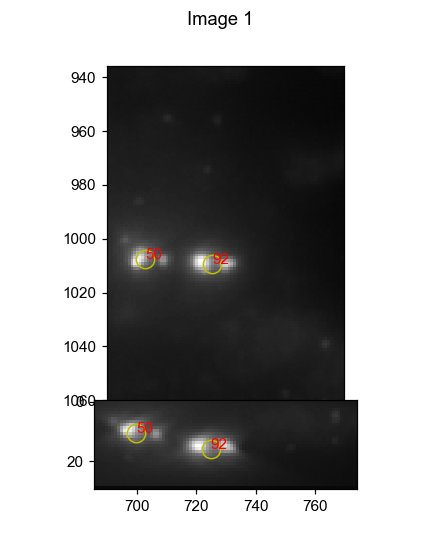

In [9]:
%matplotlib notebook
%matplotlib notebook
## visualize
coord_dict = {'coords':[np.flipud(_coord) for _coord in fov.chrom_coords],
              'class_ids':list(np.zeros(len(fov.chrom_coords),dtype=np.int)),
             }

visual_tools.imshow_mark_3d_v2([fov.chrom_im], 
                               given_dic=coord_dict,
                               save_file=None,
                               )


## select spots based on chromosomes

In [10]:
fov._load_from_file('unique', _overwrite=True)

+ loading unique from file: \\10.245.74.212\Chromatin_NAS_2\IgH_analyzed_results\20200707_IMR90_5kb_SI13\Conv_zscan_03.hdf5
++ finish loading unique in 0.034s. 


In [11]:
intensity_th = 10
from ImageAnalysis3.spot_tools.picking import assign_spots_to_chromosomes

kept_spots_list = []
for _spots in fov.unique_spots_list:
    kept_spots_list.append(_spots[_spots[:,0] > intensity_th])
# finalize candidate spots
cand_chr_spots_list = [[] for _ct in fov.chrom_coords]
for _spots in kept_spots_list:
    _cands_list = assign_spots_to_chromosomes(_spots, fov.chrom_coords)
    for _i, _cands in enumerate(_cands_list):
        cand_chr_spots_list[_i].append(_cands)
print(f"kept chromosomes: {len(fov.chrom_coords)}")

kept chromosomes: 109


In [14]:
reload(spot_tools.picking)
from ImageAnalysis3.spot_tools.picking import convert_spots_to_hzxys

dna_cand_hzxys_list = [convert_spots_to_hzxys(_spots, fov.shared_parameters['distance_zxy'])
                       for _spots in cand_chr_spots_list]
dna_reg_ids = fov.unique_ids
dna_reg_channels = fov.unique_channels
chrom_coords = fov.chrom_coords


# select_hzxys close to the chromosome center
dist_th = 3000 # upper limit is 3000nm
good_chr_th = 0.8 # 80% of regions should have candidate spots

sel_dna_cand_hzxys_list = []
sel_chrom_coords = []
chr_cand_pers = []
sel_chr_cand_pers = []
for _cand_hzxys, _chrom_coord in zip(dna_cand_hzxys_list, chrom_coords):
    _chr_cand_per = 0
    _sel_cands_list = []
    
    for _cands in _cand_hzxys:
        if len(_cands) == 0:
            _sel_cands_list.append([])
        else:
            _dists = np.linalg.norm(_cands[:,1:4] - _chrom_coord*np.array([200,108,108]), axis=1)
            _sel_cands_list.append(_cands[(_dists < dist_th)])
            _chr_cand_per += 1
    
    _chr_cand_per *= 1/len(_cand_hzxys)
    # append
    if _chr_cand_per >= good_chr_th:
        sel_dna_cand_hzxys_list.append(_sel_cands_list)
        sel_chrom_coords.append(_chrom_coord)
        sel_chr_cand_pers.append(_chr_cand_per)
    
    chr_cand_pers.append(_chr_cand_per)
    
print(f"kept chromosomes: {len(sel_chrom_coords)}")

kept chromosomes: 102


### EM pick spots

In [15]:
sel_dna_cand_hzxys_list[0]

[array([[3.0812311e+01, 2.7259126e+03, 2.3543324e+04, 1.7598466e+05],
        [4.4611881e+01, 2.7676428e+03, 2.3250240e+04, 1.7633847e+05],
        [1.6158409e+01, 3.0778193e+03, 2.3326400e+04, 1.7405466e+05]],
       dtype=float32),
 array([], shape=(0, 4), dtype=float32),
 array([[8.9404015e+01, 1.0611411e+03, 2.0218289e+04, 1.7507586e+05]],
       dtype=float32),
 array([[2.3038712e+01, 2.1725659e+03, 2.2411439e+04, 1.7178791e+05],
        [1.8133831e+01, 2.8407222e+03, 2.3228592e+04, 1.7232723e+05]],
       dtype=float32),
 array([], shape=(0, 4), dtype=float32),
 array([], shape=(0, 4), dtype=float32),
 array([], shape=(0, 4), dtype=float32),
 array([], shape=(0, 4), dtype=float32),
 array([], shape=(0, 4), dtype=float32),
 array([], shape=(0, 4), dtype=float32),
 array([], shape=(0, 4), dtype=float32),
 array([], shape=(0, 4), dtype=float32),
 array([[2.9532751e+01, 2.6483789e+03, 2.4855867e+04, 1.7431886e+05]],
       dtype=float32),
 array([], shape=(0, 4), dtype=float32),
 arr

In [12]:
%matplotlib inline
reload(spot_tools.picking)
from ImageAnalysis3.spot_tools.picking import _maximize_score_spot_picking_of_chr, pick_spots_by_intensities,pick_spots_by_scores, generate_reference_from_population, evaluate_differences

niter= 10
num_threads = 32
ref_chr_cts = None
# initialize
init_dna_hzxys = pick_spots_by_intensities(sel_dna_cand_hzxys_list)
# set save list
sel_dna_hzxys_list, sel_dna_scores_list, all_dna_scores_list = [init_dna_hzxys], [], []

for _iter in range(niter):
    print(f"+ iter:{_iter}")
    # E: generate reference
    ref_ct_dists, ref_local_dists, ref_ints = generate_reference_from_population(
        sel_dna_hzxys_list[-1], dna_reg_ids, 
        sel_dna_hzxys_list[-1], dna_reg_ids,
        ref_channels=dna_reg_channels,
        ref_chr_cts=ref_chr_cts,
        num_threads=num_threads,
        collapse_regions=True,
        split_channels=True,
        verbose=True,
    )
    
    plt.figure(figsize=(4,2), dpi=100)
    for _k, _v in ref_ct_dists.items():
        plt.hist(np.array(_v), bins=np.arange(0,5000,100), alpha=0.5, label=_k)
    plt.legend(fontsize=8)
    plt.title('center dist', fontsize=8)
    plt.show()
    
    plt.figure(figsize=(4,2), dpi=100)
    for _k, _v in ref_local_dists.items():
        plt.hist(np.array(_v), bins=np.arange(0,5000,100), alpha=0.5, label=_k)
    plt.legend(fontsize=8)
    plt.title('local dist', fontsize=8)
    plt.show()
    
    plt.figure(figsize=(4,2), dpi=100)
    for _k, _v in ref_ints.items():
        plt.hist(np.array(_v), bins=np.arange(0,500,10), alpha=0.5, label=_k)
    plt.legend(fontsize=8)
    plt.title('intensity', fontsize=8)
    plt.show()
    
    # M: pick based on scores
    sel_hzxys_list, sel_scores_list, all_scores_list, other_scores_list = \
    pick_spots_by_scores(
        sel_dna_cand_hzxys_list, dna_reg_ids,
        cand_channels=dna_reg_channels, 
        ref_hzxys_list=sel_dna_hzxys_list[-1], ref_ids=dna_reg_ids, ref_channels=dna_reg_channels,
        ref_ct_dists=ref_ct_dists, ref_local_dists=ref_local_dists, ref_ints=ref_ints, 
        ref_chr_cts=ref_chr_cts,
        num_threads=num_threads,
        collapse_regions=True,
        split_channels=True,
        return_other_scores=True,
        verbose=True,
    )
    # check updating rate
    update_rate = evaluate_differences(sel_hzxys_list, sel_dna_hzxys_list[-1])
    print(f"-- region kept: {update_rate:.4f}")
    # append
    sel_dna_hzxys_list.append(sel_hzxys_list)
    sel_dna_scores_list.append(sel_scores_list)
    all_dna_scores_list.append(all_scores_list)
    
    plt.figure(figsize=(4,2), dpi=100)
    plt.hist(np.concatenate([np.concatenate(_scores) 
                       for _scores in other_scores_list]), 
             bins=np.arange(-15,0), alpha=0.5, label='unselected')
    plt.hist(np.ravel([np.array(_sel_scores) 
                       for _sel_scores in sel_dna_scores_list[-1]]), 
             bins=np.arange(-15,0), alpha=0.5, label='selected')
    plt.legend(fontsize=8)
    plt.show()
    
    if update_rate > 0.998:
        break

NameError: name 'sel_dna_cand_hzxys_list' is not defined

In [97]:
len(final_dna_hzxys_list)

2

In [95]:
from scipy.spatial.distance import pdist, squareform
sel_iter = -1

final_dna_hzxys_list = []
kept_chr_ids = []
distmap_list = []
score_th = -6
int_th = 10
bad_spot_percentage = 0.5

for _hzxys, _scores in zip(sel_dna_hzxys_list[sel_iter], sel_dna_scores_list[sel_iter]):
    _kept_hzxys = np.array(_hzxys).copy()
    # remove spots by intensity
    _bad_inds = _kept_hzxys[:,0] < int_th
    # remove spots by scores
    _bad_inds += _scores < score_th
    #print(np.mean(_bad_inds))
    _kept_hzxys[_bad_inds] = np.nan
    
    
    if np.mean(np.isnan(_kept_hzxys).sum(1)>0)<bad_spot_percentage:
        kept_chr_ids.append(True)
        final_dna_hzxys_list.append(_kept_hzxys)
        distmap_list.append(squareform(pdist(_kept_hzxys[:,1:4])))
    else:
        kept_chr_ids.append(False)

kept_chr_ids = np.array(kept_chr_ids, dtype=np.bool)
#kept_chrom_coords = np.array(sel_chrom_coords)[kept_chr_ids]
distmap_list = np.array(distmap_list)
median_distmap = np.nanmedian(distmap_list, axis=0)

C:\Users\puzheng\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


0.4731182795698925


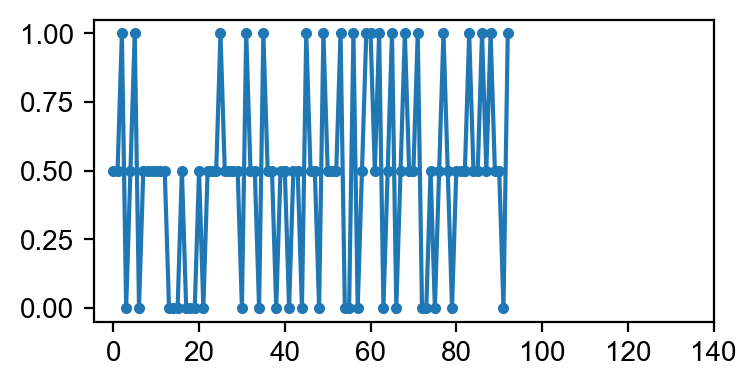

In [96]:
loss_rates = np.mean(np.sum(np.isnan(final_dna_hzxys_list), axis=2)>0, axis=0)
print(np.mean(loss_rates))
fig, ax = plt.subplots(figsize=(4,2),dpi=200)
ax.plot(loss_rates, '.-')
ax.set_xticks(np.arange(0,150,20))
plt.show()

In [ ]:
kept_inds = np.where(loss_rates<0.2)[0]

In [ ]:
imaging_order = []
for _fd, _infos in fov.color_dic.items():
    for _info in _infos:
        if len(_info) > 0 and _info[0] == 'u':
            imaging_order.append(list(dna_reg_ids).index(int(_info[1:])))
imaging_order = np.array(imaging_order, dtype=np.int)
#kept_inds = imaging_order # plot imaging ordered regions

#kept_inds = np.where(loss_rates<0.5)[0] # plot good regions only
kept_inds = np.arange(len(fov.unique_ids)) # plot all

%matplotlib inline

fig, ax = plt.subplots(figsize=(4,3),dpi=200)
ax = ia.figure_tools.distmap.plot_distance_map(median_distmap[kept_inds][:,kept_inds], 
                                               color_limits=[0,600],
                                               ax=ax,
                                               ticks=np.arange(0,150,20), 
                                               figure_dpi=500)
ax.set_title(f"proB iaa_dox_STI+, n={len(distmap_list)}", fontsize=7.5)

_ticks = np.arange(0, len(kept_inds), 20)
ax.set_xticks(_ticks)
ax.set_xticklabels(dna_reg_ids[kept_inds][_ticks])
ax.set_xlabel(f"5kb region id", fontsize=7, labelpad=2)
ax.set_yticks(_ticks)
ax.set_yticklabels(dna_reg_ids[kept_inds][_ticks])
ax.set_ylabel(f"5kb region id", fontsize=7, labelpad=2)


ax.axvline(x=np.where(fov.unique_ids[kept_inds]>300)[0][0], color=[1,1,0])
ax.axhline(y=np.where(fov.unique_ids[kept_inds]>300)[0][0], color=[1,1,0])

plt.gcf().subplots_adjust(bottom=0.1)
plt.show()

## visualize single example

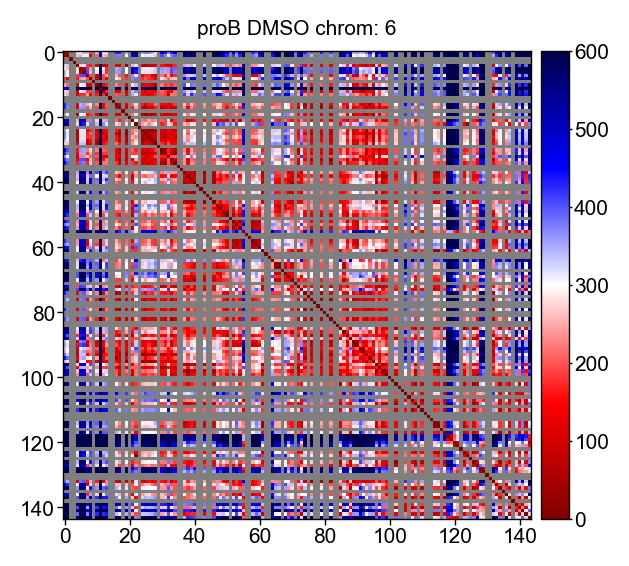

-- add colorbar with colornorm: <matplotlib.colors.Normalize object at 0x000001DC0256DCC0>


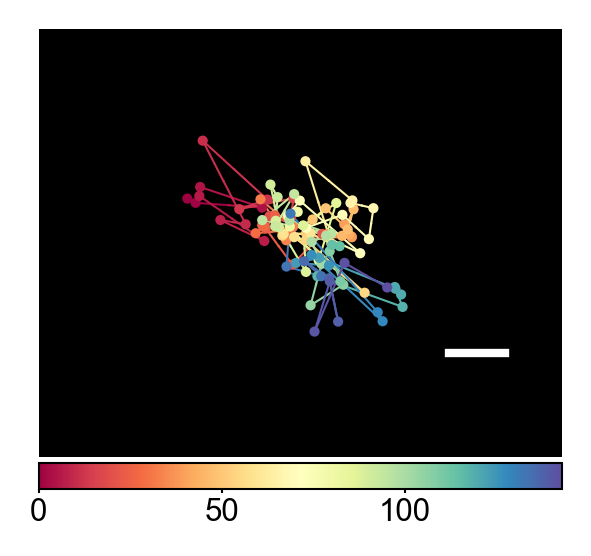

In [31]:
%matplotlib inline

reload(figure_tools.image)

chrom_id = 6

import matplotlib
import copy

sc_cmap = copy.copy(matplotlib.cm.get_cmap('seismic_r'))
sc_cmap.set_bad(color=[0.5,0.5,0.5,1])

#valid_inds = np.where(np.isnan(final_dna_hzxys_list[chrom_id]).sum(1) == 0)[0]
valid_inds = np.ones(len(final_dna_hzxys_list[chrom_id]), dtype=np.bool) # all spots

fig, ax = plt.subplots(figsize=(4,3),dpi=200)
ax = ia.figure_tools.distmap.plot_distance_map(
        distmap_list[chrom_id][valid_inds][:,valid_inds], 
        color_limits=[0,600],
        ax=ax,
        cmap=sc_cmap,
        ticks=np.arange(0,150,20), 
        figure_dpi=200)
ax.set_title(f"proB DMSO chrom: {chrom_id}", fontsize=7.5)
plt.gcf().subplots_adjust(bottom=0.1)
plt.show()

ax3d = figure_tools.image.chromosome_structure_3d_rendering(
        final_dna_hzxys_list[chrom_id][valid_inds, 1:], 
        marker_edge_line_width=0,
        reference_bar_length=200, image_radius=300, 
        line_width=0.5, figure_dpi=300, depthshade=False)
plt.show()

## visualize all fitted spots

In [101]:
with h5py.File(fov.save_filename, "r", libver='latest') as _f:
    _grp = _f['unique']
    print(_grp.keys())
    print(_grp['flags'][:3])

<KeysViewHDF5 ['channels', 'drifts', 'flags', 'ids', 'ims', 'raw_spots', 'spots']>
[1 1 1]


In [61]:
with h5py.File(fov.save_filename, "r", libver='latest') as _f:
    _grp = _f['unique']
    print(_f.attrs['shared_parameters'])

{'single_im_size': [30, 2048, 2048], 'corr_channels': ['750', '647', '561'], 'num_empty_frames': 0, 'corr_hot_pixel': True, 'corr_Z_shift': False, 'min_num_seeds': 200, 'max_num_seeds': 1000, 'spot_seeding_th': 150, 'normalize_intensity_local': False, 'normalize_intensity_background': False, 'distance_zxy': [200, 108, 108], 'sigma_zxy': [1.35, 1.9, 1.9], 'num_buffer_frames': 10, 'normalization': False, 'corr_bleed': True, 'corr_illumination': True, 'corr_chromatic': True, 'allowed_data_types': {'combo': 'c', 'decoded': 'd', 'unique': 'u', 'relabeled_unique': 'l', 'merfish': 'm', 'rna-unique': 'r', 'rna': 'r', 'gene': 'g'}, 'drift_use_fft': True, 'drift_sequential': False, 'good_drift_th': 1.0, 'drift_precision_fold': 100, 'drift_correction_args': {}, 'empty_value': 0}


(array([ 6.,  5.,  4.,  9., 10., 11.,  9., 15., 16., 14., 20., 25., 31.,
        40., 38., 28., 28., 36., 34., 36., 35., 30., 34., 31., 29., 22.,
        33., 24., 23., 21., 25., 25., 22., 23., 18., 19., 14., 18., 16.,
        12.,  5., 12.,  3.,  6., 15.,  4.,  9.,  4.,  2.,  5.,  2.,  7.,
         3.,  4.,  4.,  1.,  1.,  3.,  1.,  3.,  3.,  0.,  2.,  0.,  2.,
         0.,  0.,  0.,  2.,  1.,  0.,  0.,  2.,  0.,  1.,  0.,  0.,  0.,
         1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97,

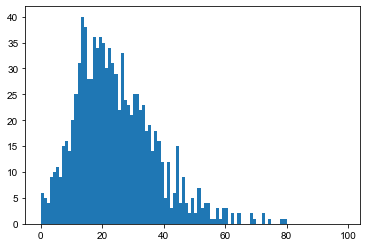

In [109]:
plt.figure()
plt.hist(fov.unique_spots_list[0][:,0], bins=np.arange(0,100,1))

In [ ]:
with h5py.File(fov.save_filename, "r", libver='latest') as _f:
    _grp = _f['unique']
    _ind = list(_grp['ids'][:]).index(41)
    _im = _grp['ims'][_ind]
    sel_drifts = _grp['drifts'][:,:]
    sel_flags = _grp['flags'][:]
    sel_ids = _grp['ids'][:]
    sel_spots = _grp['spots'][:,:,:]
    print(_ind, np.sum(_grp['spots'][1]))

<IPython.core.display.Javascript object>


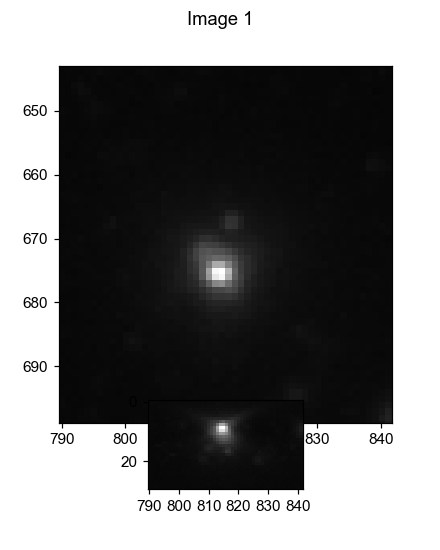

In [21]:
%matplotlib notebook
visual_tools.imshow_mark_3d_v2([_im])